In [19]:
%matplotlib inline
from fbprophet import Prophet

In [20]:
from dateutil.parser import parse
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric

In [29]:
df = pd.read_csv('data_used.csv')
df

,time,google.accounts:drive_used_quota_in_mb,google.accounts:gmail_used_quota_in_mb,google.accounts:gplus_photos_used_quota_in_mb
0,2015-03-23T00:00:00.000-0400,9537833,29158045,659544
1,2015-03-24T00:00:00.000-0400,9642866,29226034,660147
2,2015-03-25T00:00:00.000-0400,9685497,29267718,660152
3,2015-03-26T00:00:00.000-0400,9712510,29295719,661905
4,2015-03-27T00:00:00.000-0400,9730366,29312749,662475
...,...,...,...,...
1497,2019-08-13T00:00:00.000-0400,180751401,89863295,2874231
1498,2019-08-14T00:00:00.000-0400,180860832,89917638,2876476
1499,2019-08-15T00:00:00.000-0400,180993573,89968726,2879767
1500,2019-08-16T00:00:00.000-0400,181083089,90010115,2880685


In [30]:

def time_set(df):
    import datetime as dt
    df[df.columns[0]] = pd.to_datetime(df[df.columns[0]],utc = True)
    df[df.columns[0]]= df.time.dt.date
    df.set_index(df.columns[0], inplace=True)
    return df


In [31]:
def plot(df,df0):
    df1 = df.copy()
    df2 = df0.copy()
    df1 = time_set(df1)
    df2 = time_set(df2)
    for x in range(len(df1.columns)):
        plt.figure(figsize=(22, 10))
        plt.plot(df1.index, df1[df1.columns[x]], label=df1.columns[x])
        plt.plot(df2.index, df2[df2.columns[x]], label='Prophet', color='r')
        plt.legend(loc='best', fontsize='xx-large')
        plt.show()

In [32]:
def timeprediction123(df,csvfilename):
    p = Prophet(yearly_seasonality=True, seasonality_mode='multiplicative', changepoint_prior_scale=0.7)
    #changepoint_prior changes the fit of the prediction
    df = df.rename(columns={df.columns[0]: "ds", df.columns[1]: "y"})
    
    df['ds'] = pd.to_datetime(df['ds'], utc=True)
    df['ds']= df.ds.dt.date
    df.index.freq = 'D'
    #get forecast

    p.fit(df)  # df is a pandas.DataFrame with 'y' and 'ds' columns
    future = p.make_future_dataframe(periods=365)
    time_pred = p.predict(future)
    df1 = time_pred[['ds','yhat']]
    df_cv = cross_validation(p, initial='370 days', period='100 days', horizon = '100 days')
    
    df_p = performance_metrics(df_cv)
    print("Performance head for " + csvfilename)
    print(df_p.head())
    print("Performance tail for " + csvfilename)
    print(df_p.tail())

    
    #df1.to_csv(data_path_write + csvfilename)
    df2 = time_pred[['yhat']]
    p.plot(time_pred)
    return df1,df2,time_pred

In [33]:
def timepredictionMAPE(df,csvfilename):
    p = Prophet(yearly_seasonality=True, seasonality_mode='multiplicative', changepoint_prior_scale=0.7)
    #changepoint_prior changes the fit of the prediction
    df = df.rename(columns={df.columns[0]: "ds", df.columns[1]: "y"})
    
    df['ds'] = pd.to_datetime(df['ds'], utc=True)
    df['ds']= df.ds.dt.date
    df.index.freq = 'D'
    #get forecast

    p.fit(df)  # df is a pandas.DataFrame with 'y' and 'ds' columns
    future = p.make_future_dataframe(periods=365)
    time_pred = p.predict(future)
    df1 = time_pred[['ds','yhat']]
    df_cv = cross_validation(p, initial='370 days', period='100 days', horizon = '100 days')
    try:
        print("MAPE for " + csvfilename + " predictions")
        fig = plot_cross_validation_metric(df_cv, metric='mape')
    except:
        print("MAPE way too low to be graphed, prediction is very good")
    df2 = time_pred[['yhat']]
    return df1,df2,time_pred

In [34]:
def send_prediction(df):
    df_with_all_preds = timeprediction123(df = df[['time', df.columns[1]]], csvfilename = df.columns[1])[0]
    df_with_all_preds = df_with_all_preds.rename(columns= {df_with_all_preds.columns[0] : "time", df_with_all_preds.columns[1] : df.columns[1]})
    df1= df.drop(columns= [df.columns[1]])
    
    for x in range(len(df1.columns) - 1):
        h =timeprediction123(df = df1[['time', df1.columns[x+1]]], csvfilename = df1.columns[x+1])[0]
        h =h.rename(columns = {h.columns[0]: "time", h.columns[1] : df1.columns[x+1]})
        df_with_all_preds =  df_with_all_preds.merge(h, on = "time")
    return df_with_all_preds

In [35]:
def send_predictionMAPE(df):
    df_with_all_preds = timepredictionMAPE(df = df[['time', df.columns[1]]], csvfilename = df.columns[1])[0]
    df_with_all_preds = df_with_all_preds.rename(columns= {df_with_all_preds.columns[0] : "time", df_with_all_preds.columns[1] : df.columns[1]})
    df1= df.drop(columns= [df.columns[1]])
    
    for x in range(len(df1.columns) - 1):
        h =timepredictionMAPE(df = df1[['time', df1.columns[x+1]]], csvfilename = df1.columns[x+1])[0]
        h =h.rename(columns = {h.columns[0]: "time", h.columns[1] : df1.columns[x+1]})
        df_with_all_preds =  df_with_all_preds.merge(h, on = "time")
    return df_with_all_preds

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 12 forecasts with cutoffs between 2016-05-04 00:00:00 and 2019-05-09 00:00:00
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Performance head for google.accounts:drive_used_quota_in_mb
  horizon           mse          rmse           mae      mape  coverage
0 10 days  2.391874e+13  4.890679e+06  3.014068e+06  0.027152  0.306061
1 11 days  2.761132e+13  5.254647e+06  3.305505e+06  0.030396  0.270455
2 12 days  3.147534e+13  5.610288e+06  3.594081e+06  0.033677  0.250758
3 13 days  3.545082e+13  5.954059e+06  3.882106e+06  0.036903  0.231061
4 14 days  3.932113e+13  6.270656e+06  4.140797e+06  0.040031  0.222727
Performance tail for google.accounts:drive_used_quota_in_mb
    horizon           mse          rmse           mae      mape  coverage
86  96 days  3.957100e+14  1.989246e+07  1.778303e+07  0.184832  0.200000
87  97 days  3.898099e+14  1.974360e+07  1.774501e+07  0.184533  0.194545
88  98 days  3.888535e+14  1.971937e+07  1.790348e+07  0.185944  0.174380
89  99 days  3.853037e+14  1.962915e+07  1.794334e+07  0.186525  0.162810
90 100 days  3.794712e+14  1.948002e+07  1.789604e+07  0.186341  0.154545


INFO:fbprophet:Making 12 forecasts with cutoffs between 2016-05-04 00:00:00 and 2019-05-09 00:00:00
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Performance head for google.accounts:gmail_used_quota_in_mb
  horizon           mse           rmse            mae      mape  coverage
0 10 days  2.229929e+11  472221.228599  304066.607944  0.004744  0.794697
1 11 days  2.717223e+11  521269.858836  337323.327643  0.005300  0.775000
2 12 days  3.287957e+11  573407.127507  372752.069019  0.005886  0.755303
3 13 days  3.955192e+11  628903.182133  410725.409095  0.006498  0.726515
4 14 days  4.750831e+11  689262.744457  453090.532313  0.007175  0.696970
Performance tail for google.accounts:gmail_used_quota_in_mb
    horizon           mse          rmse           mae      mape  coverage
86  96 days  1.293567e+14  1.137351e+07  6.963360e+06  0.109222  0.681818
87  97 days  1.307094e+14  1.143282e+07  6.986182e+06  0.109701  0.678182
88  98 days  1.303757e+14  1.141822e+07  6.891638e+06  0.108153  0.682645
89  99 days  1.312932e+14  1.145833e+07  6.853287e+06  0.107604  0.685950
90 100 days  1.324800e+14  1.150999e+07  6.843240e+06  0.107537  0

INFO:fbprophet:Making 12 forecasts with cutoffs between 2016-05-04 00:00:00 and 2019-05-09 00:00:00


Performance head for google.accounts:gplus_photos_used_quota_in_mb
  horizon           mse          rmse           mae      mape  coverage
0 10 days  2.517472e+08  15866.544001  11821.836042  0.005970  0.317424
1 11 days  3.014573e+08  17362.524939  12981.977742  0.006628  0.297727
2 12 days  3.573787e+08  18904.462636  14188.330636  0.007313  0.278030
3 13 days  4.211860e+08  20522.817673  15469.722262  0.007996  0.258333
4 14 days  4.937939e+08  22221.473414  16958.502053  0.008856  0.225758
Performance tail for google.accounts:gplus_photos_used_quota_in_mb
    horizon           mse           rmse            mae      mape  coverage
86  96 days  1.868406e+10  136689.635323  112757.857121  0.057339  0.445455
87  97 days  1.915715e+10  138409.352091  114946.360341  0.058732  0.427273
88  98 days  1.958576e+10  139949.119410  116624.815853  0.059297  0.417355
89  99 days  1.991493e+10  141120.283359  118064.296090  0.059983  0.419835
90 100 days  2.023673e+10  142255.859698  119621.61199

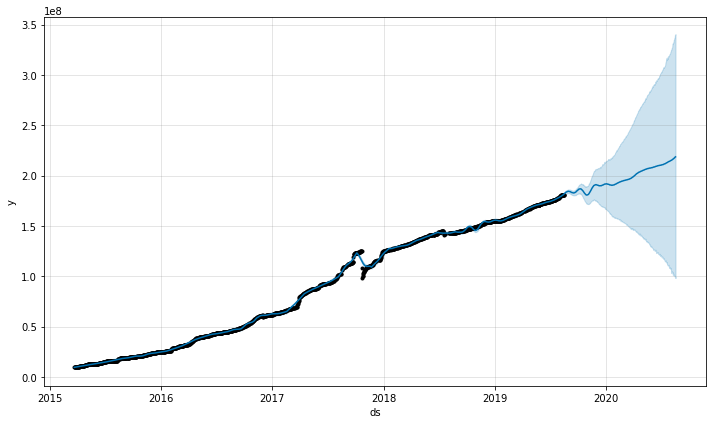

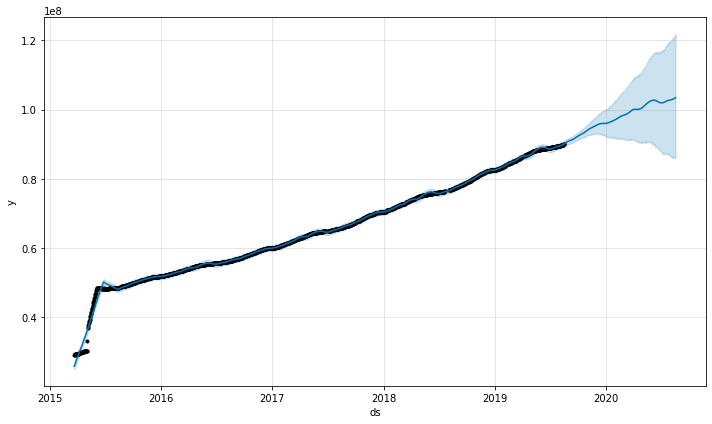

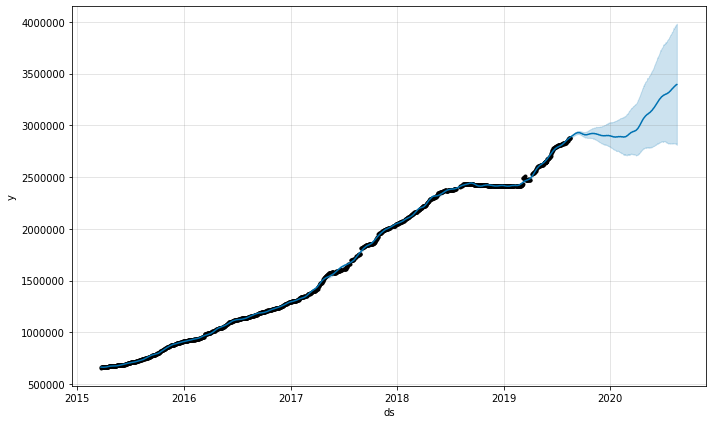

In [36]:
prediction = send_prediction(df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 12 forecasts with cutoffs between 2016-05-04 00:00:00 and 2019-05-09 00:00:00
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAPE for google.accounts:drive_used_quota_in_mb predictions


INFO:fbprophet:Making 12 forecasts with cutoffs between 2016-05-04 00:00:00 and 2019-05-09 00:00:00
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAPE for google.accounts:gmail_used_quota_in_mb predictions


INFO:fbprophet:Making 12 forecasts with cutoffs between 2016-05-04 00:00:00 and 2019-05-09 00:00:00


MAPE for google.accounts:gplus_photos_used_quota_in_mb predictions


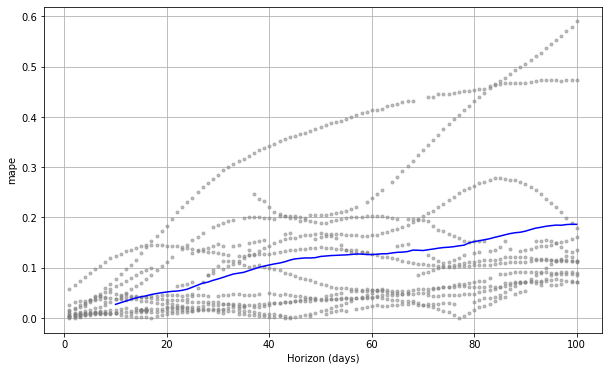

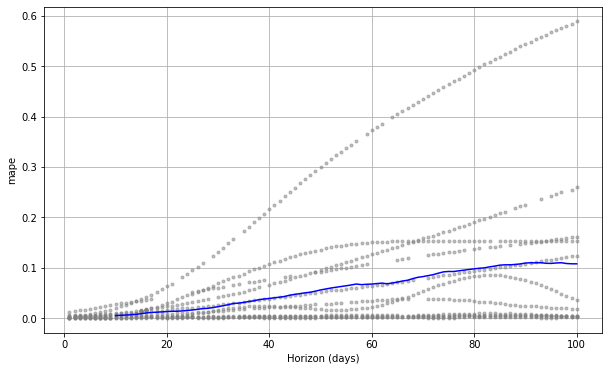

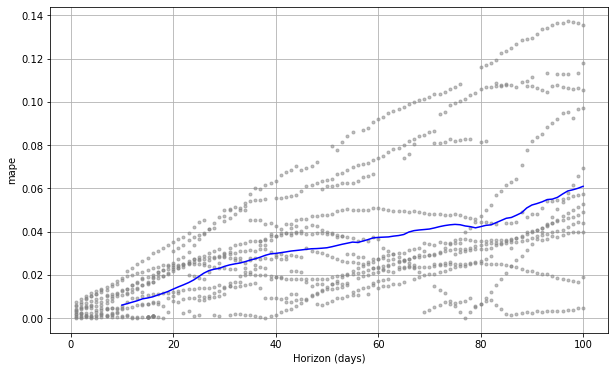

In [37]:
prediction1 = send_predictionMAPE(df)

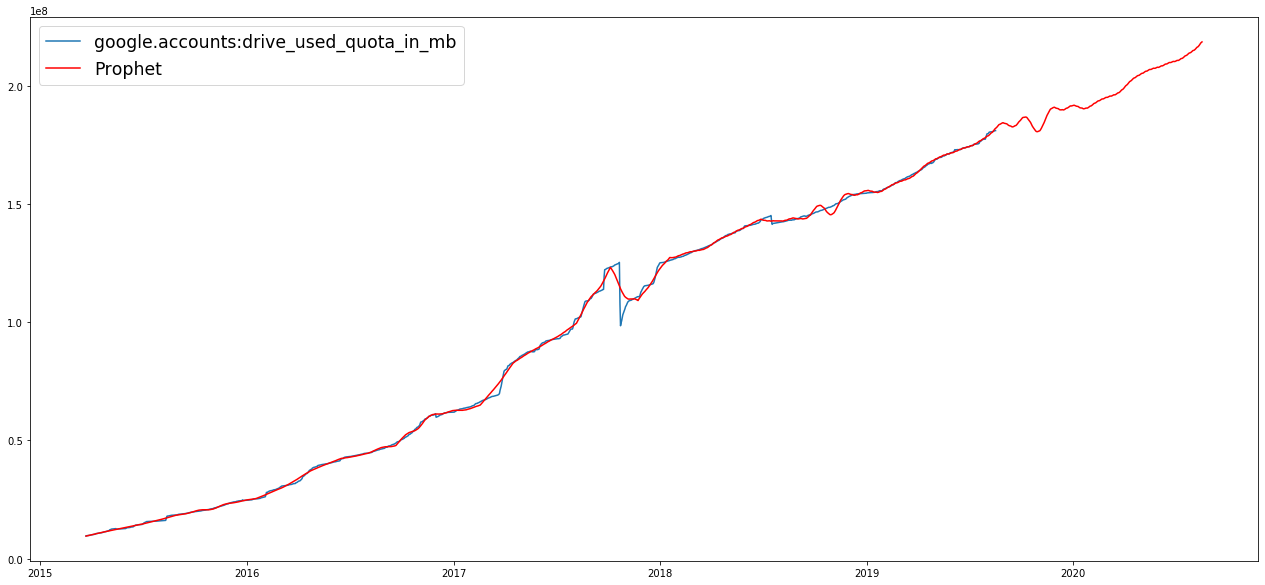

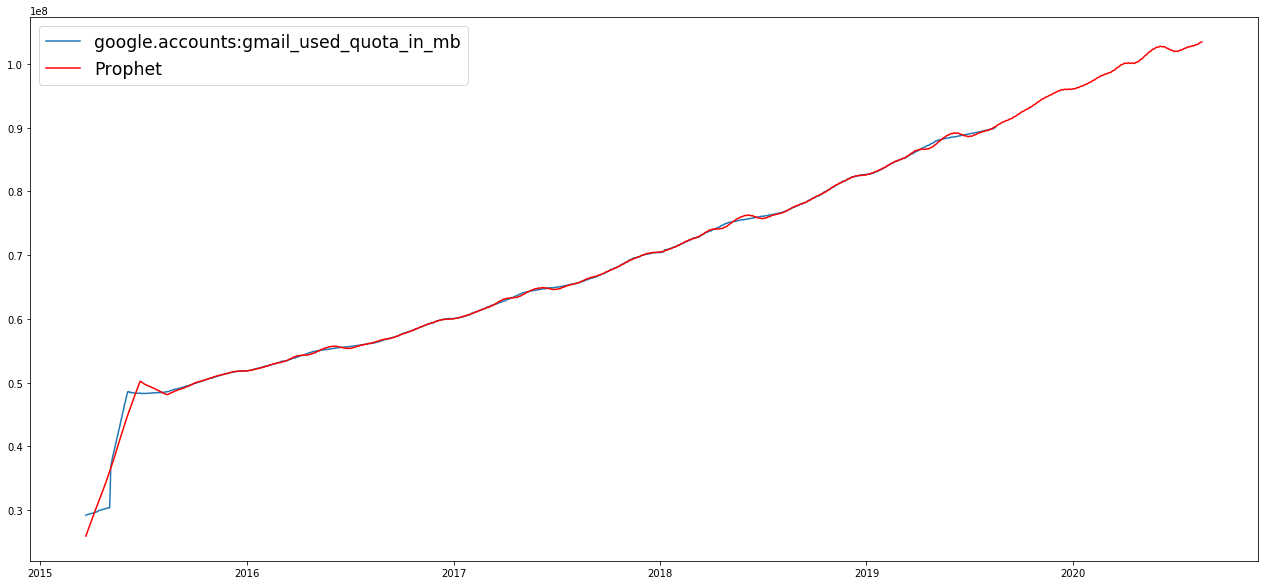

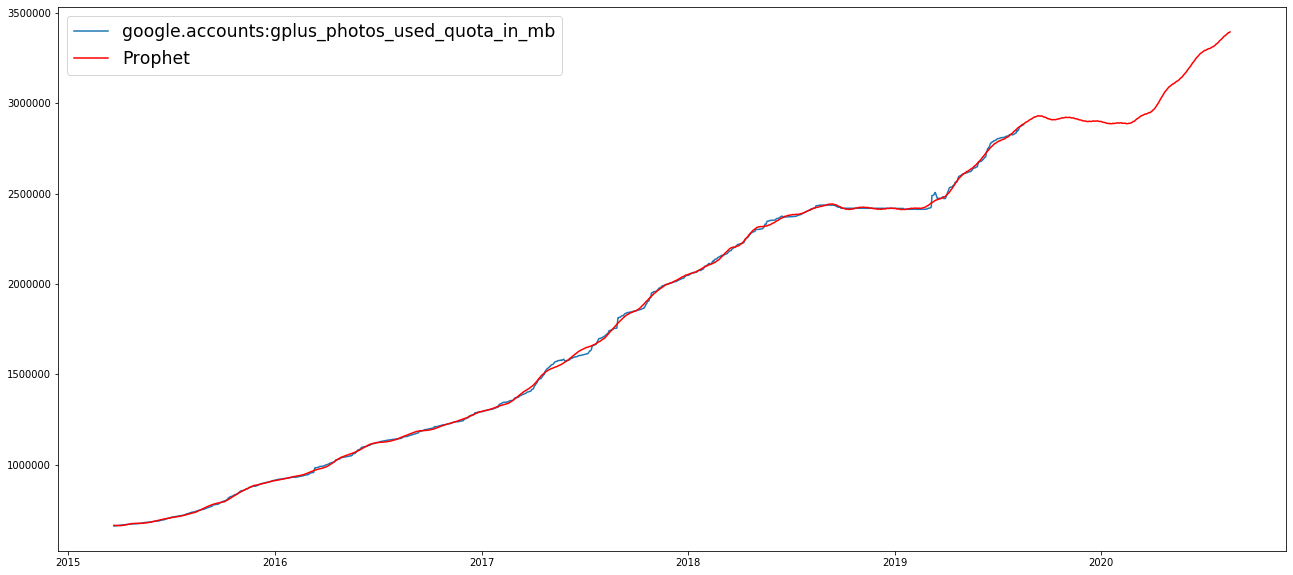

In [38]:
plot(df,prediction)